# Load Packages and Data

In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [497]:
portfolio = pd.read_json(r'data\01_raw\portfolio.json', lines=True)
profile = pd.read_json(r'data\01_raw\profile.json', lines=True)
transcript = pd.read_json(r'data\01_raw\transcript.json', lines=True)

# Portfolio Data

In [498]:
"""
portfolio.json
Offers sent during 30-day test period (10 offers x 6 fields)
    id (string) - offer id
    offer_type (string) - type of offer ie BOGO, discount, informational
    difficulty (int) - minimum required spend to complete an offer
    reward (int) - reward given for completing an offer
    duration (int) - time for offer to be open, in days
    channels (list of strings)
"""

# Load each JSON file into a pandas DataFrame
portfolio = pd.read_json(r'data\01_raw\portfolio.json', lines=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## Featurize the 'channels' column

In [499]:
# Convert 'channels' column into a string of space-separated strings
portfolio['channels'] = portfolio['channels'].apply(lambda x: ' '.join(x))

# Convert 'channels' column into separate binary columns
channels_profile = portfolio['channels'].str.get_dummies(' ')

# Concatenate the original DataFrame with the new 'channels' DataFrame
portfolio = pd.concat([portfolio, channels_profile], axis=1)

# Drop the original 'channels' column
portfolio = portfolio.drop('channels', axis=1)

# Rename the 'id' column to 'offer_id'
portfolio = portfolio.rename(columns={'id': 'offer_id'})

portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


## Summary

In [500]:
#Count of offer_ids
num_offers = portfolio['offer_id'].nunique()

#Count of offer types
offer_types = portfolio['offer_type'].nunique()

#Create a list of offer types
offer_type_list = portfolio['offer_type'].unique()

#Convert to a offer_type_list to a string
offer_type_list = ', '.join(offer_type_list)

print("The dataset contains {} unique offers that consists of {} different offer types: {}.".
      format(num_offers, offer_types, offer_type_list))

print("The offers were sent through email, mobile, social and web channels.")

#Min and Max difficulty
min_difficulty = portfolio['difficulty'].min()
max_difficulty = portfolio['difficulty'].max()

#Min and Max reward
min_reward = portfolio['reward'].min()
max_reward = portfolio['reward'].max()

print("Customers were prompted to spend from {} to {} dollars with the rewards ranging from {} to {} dollars"
      .format(min_difficulty, max_difficulty, min_reward, max_reward))

The dataset contains 10 unique offers that consists of 3 different offer types: bogo, informational, discount.
The offers were sent through email, mobile, social and web channels.
Customers were prompted to spend from 0 to 20 dollars with the rewards ranging from 0 to 10 dollars


## Featurize offer_types

In [501]:
# Convert the offer_type column into separate binary columns
offer_type_profile = pd.get_dummies(portfolio['offer_type'], prefix='offer_type')

# Convert True/False values to 1/0
offer_type_profile = offer_type_profile.astype(int)

# Concatenate the original DataFrame with the new 'offer_type' DataFrame
portfolio = pd.concat([portfolio, offer_type_profile], axis=1)

# Drop the original 'offer_type' column
portfolio = portfolio.drop('offer_type', axis=1)

#Make the offer_id the first column in the dataframe
cols = ['offer_id'] + [col for col in portfolio if col != 'offer_id']
portfolio = portfolio[cols]

portfolio.head()

,offer_id,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0


## Graph offer_types and channels

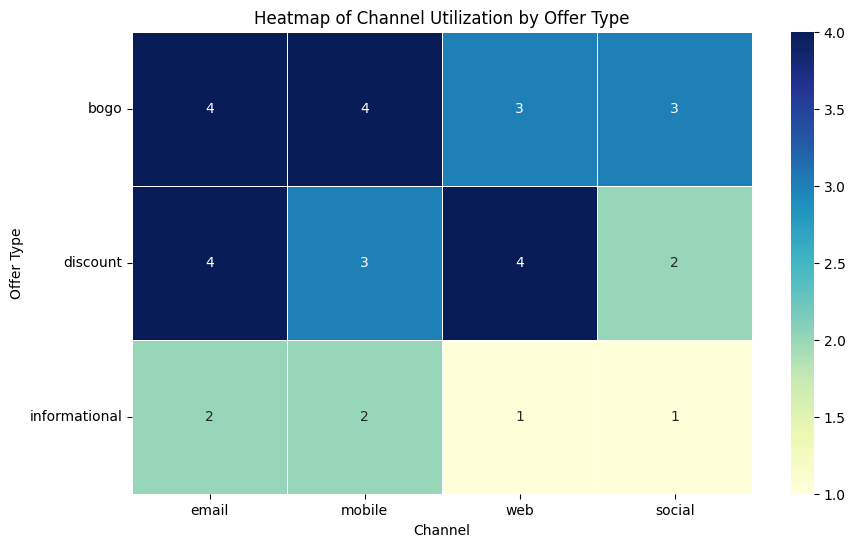

In [502]:
# Create a new DataFrame to summarize the channel utilization by offer type
channel_utilization = portfolio[['offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'email', 'mobile', 'social', 'web']]

# Group by offer type and sum the channels
channel_utilization_summary = channel_utilization.groupby(['offer_type_bogo', 'offer_type_discount', 'offer_type_informational']).sum()

# Reset index to make the DataFrame easier to handle
channel_utilization_summary.reset_index(inplace=True)

# Map offer type columns to a single 'offer_type' column for easier plotting
channel_utilization_summary['offer_type'] = channel_utilization_summary.apply(
    lambda row: 'bogo' if row['offer_type_bogo'] == 1 else ('discount' if row['offer_type_discount'] == 1 else 'informational'), axis=1)

# Drop the offer type indicator columns
channel_utilization_summary.drop(columns=['offer_type_bogo', 'offer_type_discount', 'offer_type_informational'], inplace=True)

# Set 'offer_type' as the index
channel_utilization_summary.set_index('offer_type', inplace=True)

# Sum the rows and columns, sort them in descending order, and reorder the DataFrame based on these sums
row_sums = channel_utilization_summary.sum(axis=1).sort_values(ascending=False)
col_sums = channel_utilization_summary.sum(axis=0).sort_values(ascending=False)
channel_utilization_summary = channel_utilization_summary.loc[row_sums.index, col_sums.index]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(channel_utilization_summary, annot=True, cmap='YlGnBu', fmt='d', linewidths=.5)

plt.title('Heatmap of Channel Utilization by Offer Type')
plt.xlabel('Channel')
plt.ylabel('Offer Type')

# Rotate y-axis labels
plt.yticks(rotation=0)

plt.show()

## Export Featurized Data

In [503]:
#Export the cleaned data to .csv
portfolio.to_csv(r'data\02_stg\stg_portfolio.csv', index=False)

#Pickle the cleaned data
portfolio.to_pickle(r'data\02_stg\stg_portfolio.pkl')

# Profile Data

In [504]:
"""
profile.json
Rewards program users (17000 users x 5 fields)
Details the different offers sent during the test period, including offer type (buy-one-get-one, discount, informational), reward amount, required spending threshold, duration, and delivery channels.
    age (int) - age of the customer (missing value is encoded as 118)
    became_member_on (int) - date when customer created an app account
    gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
    id (str) - customer id
    income (float) - customer's income

"""
### Clean up the profile data ###
# Rename the 'id' column to 'customer_id'
profile = profile.rename(columns={'id': 'customer_id'})

#make customer id the first column
cols = ['customer_id'] + [col for col in profile if col != 'customer_id']
profile = profile[cols]

#Convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Calculate membership duration in days from the max date in the dataset
profile['days_as_member'] = (profile['became_member_on'].max()- profile['became_member_on']).dt.days

# Replace None with NaN
profile['gender'] = profile['gender'].fillna(np.nan)

# Replace 118 with NaN
profile['age'] = profile['age'].replace(118, np.nan)

# Save the cleaned data 
profile.to_csv(r'data\02_stg\stg_profile.csv', index=False)
profile.to_pickle(r'data\02_stg\stg_profile.pkl')

profile.head()

,customer_id,gender,age,became_member_on,income,days_as_member
0,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,2017-02-12,NaN,529
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,376
2,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN,2018-07-12,NaN,14
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,443
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,2017-08-04,NaN,356


In [505]:
#Split the data set into two dataframes. One with missing values and one without
#Create the dataframe with missing values
profile_missing = profile[profile.isnull().any(axis=1)]
profile_missing = profile.reset_index(drop=True)\

#Export the dataframes to .csv and .pkl
profile_missing.to_csv(r'data\03_int\int_profile_missing.csv', index=False)
profile_missing.to_pickle(r'data\03_int\int_profile_missing.pkl')

#Create the dataframe without missing values
profile_clean = profile.dropna()
profile_clean = profile_clean.reset_index(drop=True)

#Export the dataframes to .csv and .pkl
profile_clean.to_csv(r'data\03_int\int_profile_clean.csv', index=False)
profile_clean.to_pickle(r'data\03_int\int_profile_clean.pkl')

profile_clean.head()

,customer_id,gender,age,became_member_on,income,days_as_member
0,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,376
1,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,443
2,e2127556f4f64592b11af22de27a7932,M,68.0,2018-04-26,70000.0,91
3,389bc3fa690240e798340f5a15918d5c,M,65.0,2018-02-09,53000.0,167
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58.0,2017-11-11,51000.0,257


## Summary

### Data Density

In [506]:
# Percentage of missing values in each column
nan_percent = round(profile.isna().mean() * 100, 2)
print(nan_percent)

customer_id          0.00
gender              12.79
age                 12.79
became_member_on     0.00
income              12.79
days_as_member       0.00
dtype: float64


### Data Distribution

In [507]:
# For profile[['days_as_member', 'age', 'income']], call the describe method and then transpose the results
profile_statistics = profile[['days_as_member', 'age', 'income']].describe().astype(int)

#Add a row that calculates the range for each column
profile_range = (profile[['days_as_member', 'age', 'income']].max() - profile[['days_as_member', 'age', 'income']].min()).astype(int)
profile_range = profile_range.to_frame().T
profile_range.index = ['range']

#Concatenate the two DataFrames
profile_statistics = pd.concat([profile_statistics, profile_range]).T

#Save cleaned data to .csv
profile_statistics.to_csv(r'data\04_fct\fct_profile_statistics.csv', index=False)

profile_statistics.head()

,count,mean,std,min,25%,50%,75%,max,range
days_as_member,17000,517,411,0,208,358,791,1823,1823
age,14825,54,17,18,42,55,66,101,83
income,14825,65404,21598,30000,49000,64000,80000,120000,90000


In [508]:
# Calculate value counts
gender_counts = profile['gender'].value_counts(dropna=False).to_frame().reset_index()
gender_counts.columns = ['Gender', 'Count']

# Calculate percentages
gender_percentages = profile['gender'].value_counts(normalize=True, dropna=False).mul(100).round(2).to_frame().reset_index()
gender_percentages.columns = ['Gender', 'Percentage']

# Merge the two DataFrames
gender_stats = pd.merge(gender_counts, gender_percentages, on='Gender')
gender_stats

,Gender,Count,Percentage
0,M,8484,49.91
1,F,6129,36.05
2,NaN,2175,12.79
3,O,212,1.25


Interesting! Why are there 13.86% more men signed up for the rewards program?

## Segmenting Customers

### Categorize Data

In [509]:
#Create age categories
bins = [18, 25, 35, 45, 55, 65, 75, 102]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
profile['age_group'] = pd.cut(profile['age'], bins=bins, labels=labels, right=False)
profile = profile.drop('age', axis=1)

#Create income categories
bins = [30000, 50000, 75000, 100000, 120001]
labels = ['<50K', '50K-74K', '75K-99K', '100K+']
profile['income_group'] = pd.cut(profile['income'], bins=bins, labels=labels, right=False)
profile = profile.drop('income', axis=1)

# Convert 'became_member_on' to datetime if it's not already
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])

# Extract the quarter and year from the 'became_member_on' date
profile['membership_quarter'] = profile['became_member_on'].dt.quarter
profile['membership_year'] = profile['became_member_on'].dt.year

# Combine the quarter and year into a single column
profile['member_since'] = profile['membership_year'].astype(str) + ' Q' + profile['membership_quarter'].astype(str)

# Drop the 'days_as_member', 'became_member_on', 'membership_quarter', and 'membership_year' columns
profile = profile.drop(['days_as_member', 'became_member_on', 'membership_quarter', 'membership_year'], axis=1)

#Split the data set into two dataframes. One with missing values and one without
#Create the dataframe with missing values
cat_profile_missing = profile[profile.isnull().any(axis=1)]
cat_profile_missing = cat_profile_missing.reset_index(drop=True)\

#Export the dataframes to .csv and .pkl
cat_profile_missing.to_csv(r'data\03_int\int_cat_profile_missing.csv', index=False)
cat_profile_missing.to_pickle(r'data\03_int\int_cat_profile_missing.pkl')

#Create the dataframe without missing values
cat_profile_clean = profile.dropna()
cat_profile_clean = cat_profile_clean.reset_index(drop=True)

#Export the dataframes to .csv and .pkl
cat_profile_clean.to_csv(r'data\03_int\int_cat_profile_clean.csv', index=False)
cat_profile_clean.to_pickle(r'data\03_int\int_cat_profile_clean.pkl')

cat_profile_clean.head()

,customer_id,gender,age_group,income_group,member_since
0,0610b486422d4921ae7d2bf64640c50b,F,55-64,100K+,2017 Q3
1,78afa995795e4d85b5d9ceeca43f5fef,F,75+,100K+,2017 Q2
2,e2127556f4f64592b11af22de27a7932,M,65-74,50K-74K,2018 Q2
3,389bc3fa690240e798340f5a15918d5c,M,65-74,50K-74K,2018 Q1
4,2eeac8d8feae4a8cad5a6af0499a211d,M,55-64,50K-74K,2017 Q4


In [510]:
# Group by the categorical variables and count the number of customer_ids
cat_vars = ['gender', 'age_group', 'income_group', 'member_since']
max_seg = cat_profile_clean.groupby(cat_vars, observed=True)['customer_id'].count()

# Convert the max_seg data to a DataFrame and reset the index
df_max_seg = max_seg.reset_index()

# Rename the customer_id column to count
df_max_seg.rename(columns={'customer_id': 'cust_count'}, inplace=True)
df_max_seg = df_max_seg.sort_values('cust_count', ascending=False)

# Save the data to a .csv file
df_max_seg.to_csv(r'data\04_fct\fct_max_seg.csv', index=False)

df_max_seg.head()

,gender,age_group,income_group,member_since,cust_count
629,M,45-54,50K-74K,2017 Q4,128
705,M,55-64,50K-74K,2017 Q3,110
707,M,55-64,50K-74K,2018 Q1,98
782,M,65-74,50K-74K,2017 Q4,98
631,M,45-54,50K-74K,2018 Q2,98


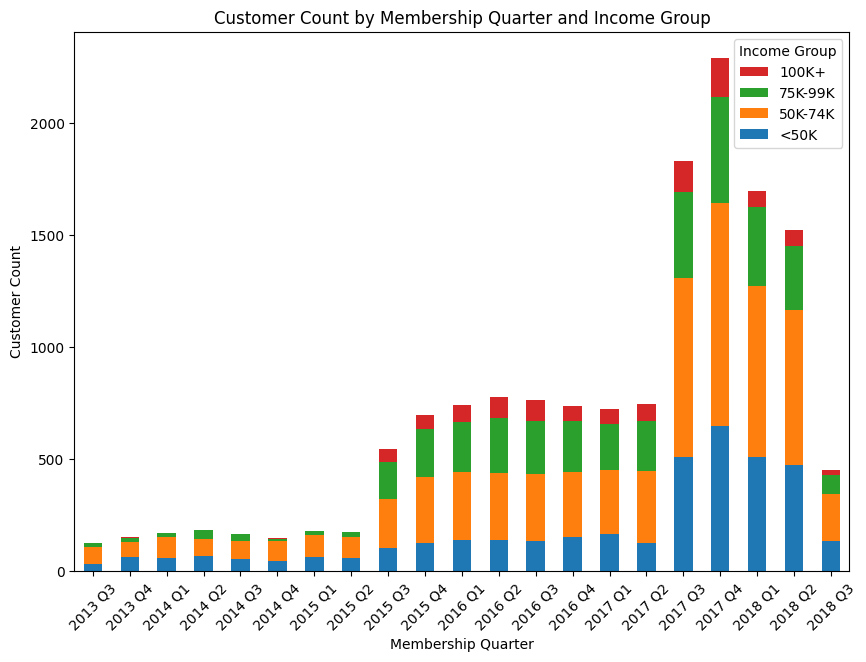

In [511]:
# Aggregate the data
df_agg = df_max_seg.groupby(['member_since', 'income_group'], observed=True)['cust_count'].sum().reset_index()

# Pivot the DataFrame so that each income group is a separate column
df_pivot = df_agg.pivot(index='member_since', columns='income_group', values='cust_count')

# Plot a stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10,7))

# Angle the x-axis labels
plt.xticks(rotation=45)

# Sort the legend in descending order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Income Group')

# Add a title and labels for the x and y axes
plt.title('Customer Count by Membership Quarter and Income Group')
plt.xlabel('Membership Quarter')
plt.ylabel('Customer Count')

# Show the plot
plt.show()

### KModes Clustering

Optimal amount of clusters according to the elbow method:  2


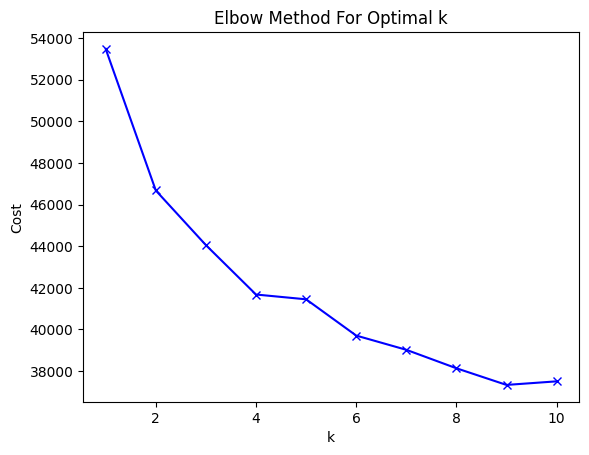

In [518]:
def optimal_num_clusters(data, max_clusters):
    costs = []
    for num_clusters in range(1, max_clusters+1):
        np.random.seed(42)  # Set the seed here
        km = KModes(n_clusters=num_clusters, init='Huang', n_init=5, verbose=0)
        km.fit_predict(data)
        costs.append(km.cost_)

    # Calculate the difference in costs
    diff_costs = np.diff(costs)

    # Find the elbow point -> this is not working. I need the smallest negative number
    optimal_clusters = np.nanargmin(diff_costs) + 2  # +2 because the index starts at 0 and we started num_clusters at 1

    return optimal_clusters, costs, diff_costs  # Return costs as well

# Use the function to find the optimal number of clusters
optimal_clusters, costs, diff_costs = optimal_num_clusters(cat_profile_clean, 10)
print("Optimal amount of clusters according to the elbow method: ", optimal_clusters)

plt.plot(range(1,11), costs, 'bx-')  # Plot costs
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [528]:
# Create a DataFrame
kmodes_cost = pd.DataFrame({
    'k': range(1, 11),
    'cost': costs,
    'diff_costs': np.insert(diff_costs, 0, np.nan)
})

# Calculate the percent change in cost
kmodes_cost['percent_change'] = kmodes_cost['cost'].pct_change() * 100

#Save to .csv
kmodes_cost.to_csv(r'data\04_fct\fct_profile_kmodes_cost.csv', index=False)

# Print the DataFrame
kmodes_cost

,k,cost,diff_costs,percent_change
0,1,53478.0,NaN,NaN
1,2,46677.0,-6801.0,-12.717379
2,3,44053.0,-2624.0,-5.621612
3,4,41679.0,-2374.0,-5.388963
4,5,41449.0,-230.0,-0.551837
5,6,39707.0,-1742.0,-4.202755
6,7,39023.0,-684.0,-1.722618
7,8,38136.0,-887.0,-2.273018
8,9,37336.0,-800.0,-2.097755
9,10,37508.0,172.0,0.460681


In [514]:
# Assuming cat_profile_clean is your DataFrame and customer_id is the index
profile_kmode = cat_profile_clean.copy()

# Perform KModes clustering
km = KModes(n_clusters=optimal_clusters, init='Huang', n_init=5, verbose=0)  # Change the number of clusters as needed
clusters = km.fit_predict(profile_kmode)

# Add the cluster labels to your new DataFrame
profile_kmode['kmodes_cluster'] = clusters

# Save to .csv
profile_kmode.to_csv(r'data\04_fct\fct_profile_kmode_cluster.csv', index=True)

# Pickle the cleaned data
profile_kmode.to_pickle(r'data\04_fct\fct_profile_kmode_cluster.pkl')

profile_kmode.head()

,customer_id,gender,age_group,income_group,member_since,kmodes_cluster
0,0610b486422d4921ae7d2bf64640c50b,F,55-64,100K+,2017 Q3,0
1,78afa995795e4d85b5d9ceeca43f5fef,F,75+,100K+,2017 Q2,0
2,e2127556f4f64592b11af22de27a7932,M,65-74,50K-74K,2018 Q2,1
3,389bc3fa690240e798340f5a15918d5c,M,65-74,50K-74K,2018 Q1,1
4,2eeac8d8feae4a8cad5a6af0499a211d,M,55-64,50K-74K,2017 Q4,0


In [515]:
# Creating a dataframe to understand the cluster profiles
centroids_df = pd.DataFrame(km.cluster_centroids_, columns=profile_kmode.columns[1:])

# Count the number of customers in each cluster
num_customers = np.bincount(km.labels_)
centroids_df['num_customers'] = num_customers

#Calculate the percent of customers that are in these centroids
centroids_df['customer_percent'] = round(centroids_df['num_customers'] / centroids_df['num_customers'].sum() * 100, 2)

#The customer segements in the dataframe below are the centroids of the clusters
centroids_df

,gender,age_group,income_group,member_since,kmodes_cluster,num_customers,customer_percent
0,0011e0d4e6b944f998e987f904e8c1e5,F,55-64,50K-74K,2017 Q4,8480,57.2
1,0009655768c64bdeb2e877511632db8f,M,45-54,50K-74K,2017 Q3,6345,42.8


## KPrototypes Clustering

In [459]:
#Import 'data\03_int\int_profile_clean.pkl'
profile_clean = pd.read_pickle(r'data\03_int\int_profile_clean.pkl')

#Drop 'became_member_on' column
profile_clean = profile_clean.drop('became_member_on', axis=1)

# Set 'customer_id' as the index
profile_clean = profile_clean.set_index('customer_id')

profile_clean.head()

,gender,age,income,days_as_member
customer_id,,,,
0610b486422d4921ae7d2bf64640c50b,F,55.0,112000.0,376
78afa995795e4d85b5d9ceeca43f5fef,F,75.0,100000.0,443
e2127556f4f64592b11af22de27a7932,M,68.0,70000.0,91
389bc3fa690240e798340f5a15918d5c,M,65.0,53000.0,167
2eeac8d8feae4a8cad5a6af0499a211d,M,58.0,51000.0,257


### Elbow Score Implementation

The optimal number of clusters is:  9


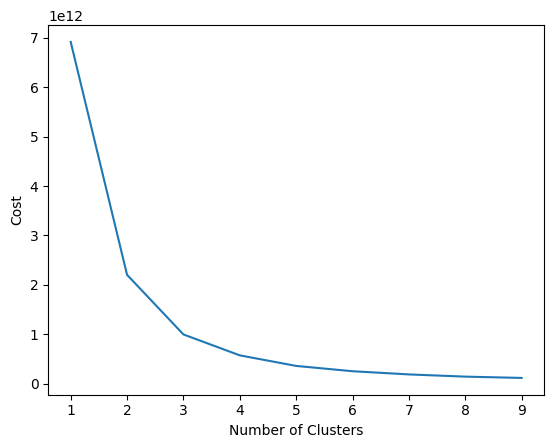

In [453]:
#### Note: This code takes about 4 minutes to run ####
costs = []
cluster_labels = []
for num_clusters in range(1, 10):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    labels = kproto.fit_predict(profile_clean, categorical=[0])  # 'gender' is now the first column
    costs.append(kproto.cost_)
    cluster_labels.append(labels)

# Choose the number of clusters that gave the lowest cost
optimal_num_clusters = costs.index(min(costs)) + 1
print("The optimal number of clusters is: ", optimal_num_clusters)

profile_clean['cluster'] = cluster_labels[optimal_num_clusters - 1]

plt.plot(range(1, 10), costs)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

In [457]:
# Create a DataFrame with the number of clusters and the associated cost
kproto_cost = pd.DataFrame({'clusters': range(1, 10), 'cost': costs})

# Calculate the percent change in cost
kproto_cost['percent_change'] = kproto_cost['cost'].pct_change() * 100

kproto_cost

,clusters,cost,percent_change
0,1,6.917829e+12,NaN
1,2,2.204077e+12,-68.139176
2,3,9.973711e+11,-54.748816
3,4,5.741527e+11,-42.433391
4,5,3.602455e+11,-37.256154
5,6,2.529092e+11,-29.795322
6,7,1.883093e+11,-25.542738
7,8,1.434829e+11,-23.804677
8,9,1.173846e+11,-18.189136


# Transcript Data

In [429]:
"""
Event log (306648 events x 4 fields)
Logs all events related to offers and transactions, such as offer receipt, offer view, transaction amount, and offer completion, along with timestamps
    event (str) - record description (ie transaction, offer received, offer viewed, etc.)
    person (str) - customer id
    time (int) - time in hours since start of test. The data begins at time t=0
    value - (dict of strings) - either an offer id or transaction amount depending on the record

"""
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
